<a href="https://colab.research.google.com/github/meituan/YOLOv6/blob/main/inference.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#@title Set-up model. { run: "auto" }
# checkpoint:str ="yolov6n" #@param ["yolov6s", "yolov6n", "yolov6t"]
checkpoint:str = "runs/train/yolov6s6_cat/weights/best_ckpt"
device:str = "cpu"#@param ["gpu", "cpu"]
half:bool = False #@param {type:"boolean"}


import os, requests, torch, math, cv2
import numpy as np
import PIL
#Change directory so that imports wortk correctly
if os.getcwd()=="/content":
  os.chdir("YOLOv6")
from yolov6.utils.events import LOGGER, load_yaml
from yolov6.layers.common import DetectBackend
from yolov6.data.data_augment import letterbox
from yolov6.utils.nms import non_max_suppression
from yolov6.core.inferer import Inferer

from typing import List, Optional

if not os.path.exists(f"{checkpoint}.pt"):
  print("No checkpoint...")

#Set-up hardware options
cuda = device != 'cpu' and torch.cuda.is_available()
device = torch.device('cuda:0' if cuda else 'cpu')
  
def check_img_size(img_size, s=32, floor=0):
  def make_divisible( x, divisor):
    # Upward revision the value x to make it evenly divisible by the divisor.
    return math.ceil(x / divisor) * divisor
  """Make sure image size is a multiple of stride s in each dimension, and return a new shape list of image."""
  if isinstance(img_size, int):  # integer i.e. img_size=640
      new_size = max(make_divisible(img_size, int(s)), floor)
  elif isinstance(img_size, list):  # list i.e. img_size=[640, 480]
      new_size = [max(make_divisible(x, int(s)), floor) for x in img_size]
  else:
      raise Exception(f"Unsupported type of img_size: {type(img_size)}")

  if new_size != img_size:
      print(f'WARNING: --img-size {img_size} must be multiple of max stride {s}, updating to {new_size}')
  return new_size if isinstance(img_size,list) else [new_size]*2

def precess_image(path, img_size, stride, half):
  '''Process image before image inference.'''
  img_src = cv2.imread(path)
  img_src = cv2.cvtColor(img_src, cv2.COLOR_BGR2RGB)
  image = letterbox(img_src, img_size, stride=stride)[0]

  # Convert
  image = image.transpose((2, 0, 1))[::-1]  # HWC to CHW, BGR to RGB
  image = torch.from_numpy(np.ascontiguousarray(image))
  image = image.half() if half else image.float()  # uint8 to fp16/32
  image /= 255  # 0 - 255 to 0.0 - 1.0

  return image, img_src


model = DetectBackend(f"./{checkpoint}.pt", device=device)
stride = model.stride
class_names = load_yaml("./data/dataset.yaml")['names']

if half & (device.type != 'cpu'):
  model.model.half()
else:
  model.model.float()
  half = False

if device.type != 'cpu':
  model(torch.zeros(1, 3, *img_size).to(device).type_as(next(model.model.parameters())))  # warmup


/home/hoangphuc/miniconda3/envs/wowAI/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Loading checkpoint from ./runs/train/yolov6s6_cat/weights/best_ckpt.pt

Fusing model...


/home/hoangphuc/miniconda3/envs/wowAI/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3190.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


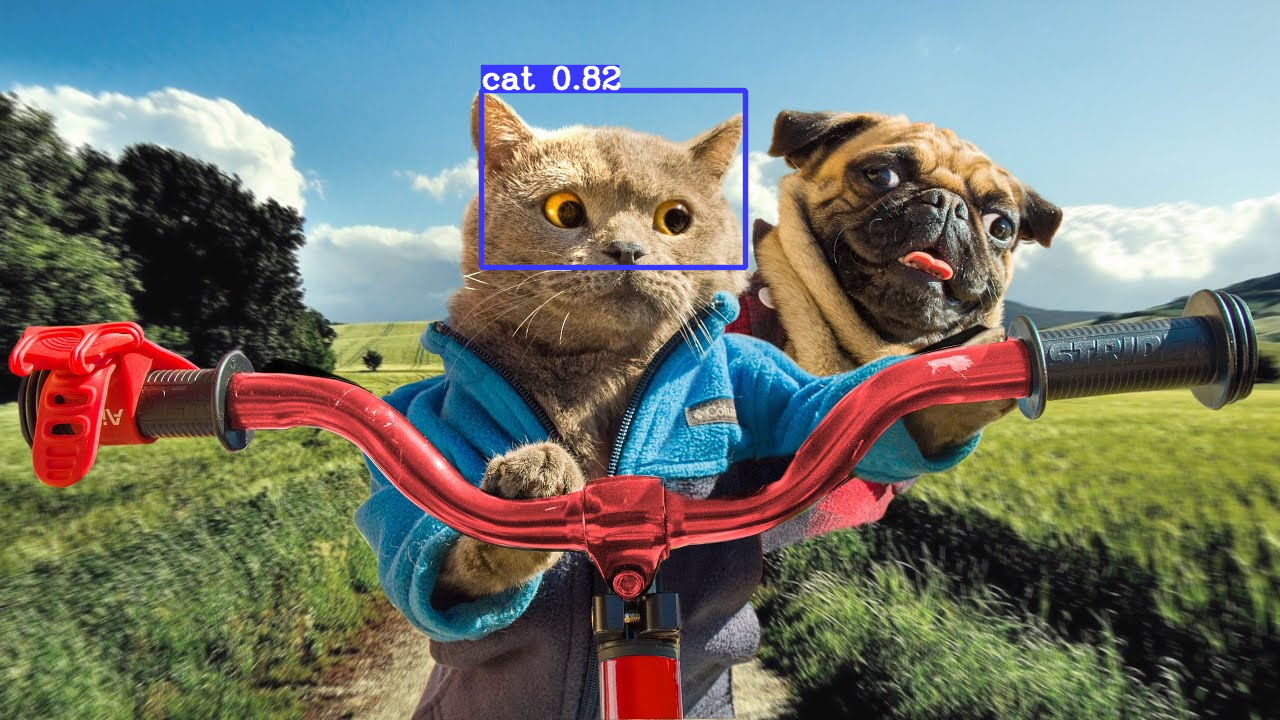

In [2]:
#@title Run YOLOv6 on an image from a URL. { run: "auto" }
img_path = "img_test/cat_dog3.jpg"
hide_labels: bool = False #@param {type:"boolean"}
hide_conf: bool = False #@param {type:"boolean"}



img_size:int = 640#@param {type:"integer"}

conf_thres: float =.5 #@param {type:"number"}
iou_thres: float =.45 #@param {type:"number"}
max_det:int =  1000#@param {type:"integer"}
agnostic_nms: bool = False #@param {type:"boolean"}


img_size = check_img_size(img_size, s=stride)

img, img_src = precess_image(img_path, img_size, stride, half)
img = img.to(device)
if len(img.shape) == 3:
    img = img[None]
    # expand for batch dim
pred_results = model(img)
classes:Optional[List[int]] = None # the classes to keep
det = non_max_suppression(pred_results, conf_thres, iou_thres, classes, agnostic_nms, max_det=max_det)[0]

gn = torch.tensor(img_src.shape)[[1, 0, 1, 0]]  # normalization gain whwh
img_ori = img_src.copy()
if len(det):
  det[:, :4] = Inferer.rescale(img.shape[2:], det[:, :4], img_src.shape).round()
  for *xyxy, conf, cls in reversed(det):
      class_num = int(cls)
      label = None if hide_labels else (class_names[class_num] if hide_conf else f'{class_names[class_num]} {conf:.2f}')
      Inferer.plot_box_and_label(img_ori, max(round(sum(img_ori.shape) / 2 * 0.003), 2), xyxy, label, color=Inferer.generate_colors(class_num, True))
PIL.Image.fromarray(img_ori)